<a href="https://colab.research.google.com/github/sarcasticvibes/Bengali-Character-classification-via-ResNet34/blob/master/Bengali_Character_Classification_via_ResNet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bengali Character Classification via ResNet34
---

> I'm using **ResNet34** from `pretrained` module and fine tuning it for this classifivation task.

> In this task, we are given images of Bengali characters and we have to identify the *consonant diacritic*, *vowel diacritic* and the *grapheme root*.

> I'm making a single model which makes 3 predictions, one for each of the above categories thus adding 3 fully connected layers to the pretraines network.

## Downloading the required libraries and dataset from Kaggle
---

In [ ]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarcasticvibes","key":"bfda3feb2819ca823cca634e7b3e67e7"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c 'bengaliai-cv19'

  0% 0.00/1.32M [00:00<?, ?B/s]
100% 1.32M/1.32M [00:00<00:00, 43.9MB/s]
  0% 0.00/1.70k [00:00<?, ?B/s]
100% 1.70k/1.70k [00:00<00:00, 1.77MB/s]
  0% 0.00/4.75k [00:00<?, ?B/s]
100% 4.75k/4.75k [00:00<00:00, 4.99MB/s]
  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 178MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 175MB/s]
  0% 0.00/4.72k [00:00<?, ?B/s]
100% 4.72k/4.72k [00:00<00:00, 14.3MB/s]
  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 182MB/s]
  0% 0.00/16.8k [00:00<?, ?B/s]
100% 16.8k/16.8k [00:00<00:00, 17.3MB/s]
  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18M [00:00<00:00, 168MB/s]
  0% 0.00/944 [00:00<?, ?B/s]
100% 944/944 [00:00<00:00, 816kB/s]
 99% 972M/986M [00:08<00:00, 117MB/s] 
100% 986M/986M [00:08<00:00, 120MB/s]
100% 990M/993M [00:11<00:00, 38.6MB/s]
100% 993M/993M [00:11<00:00, 92.5MB/s]
100% 990M/992M [00:26<00:00, 49.8MB/s]
100% 992M/992M [00:26<00:00, 38.8MB/s]
 99% 985M/991M [00:25<00:00, 37.0MB/s]
100% 991M

In [5]:
! mkdir training_set
! mkdir image_pickles
! mkdir testing_set
! mkdir image_pickles_test

In [6]:
! unzip train_image_data_0.parquet.zip -d training_set
! unzip train_image_data_1.parquet.zip -d training_set
! unzip train_image_data_2.parquet.zip -d training_set
! unzip train_image_data_3.parquet.zip -d training_set
! unzip train.csv.zip -d training_set

Archive:  train_image_data_0.parquet.zip
  inflating: training_set/train_image_data_0.parquet  
Archive:  train_image_data_1.parquet.zip
  inflating: training_set/train_image_data_1.parquet  
Archive:  train_image_data_2.parquet.zip
  inflating: training_set/train_image_data_2.parquet  
Archive:  train_image_data_3.parquet.zip
  inflating: training_set/train_image_data_3.parquet  
Archive:  train.csv.zip
  inflating: training_set/train.csv  


In [7]:
! unzip test_image_data_0.parquet.zip -d testing_set
! unzip test_image_data_1.parquet.zip -d testing_set
! unzip test_image_data_2.parquet.zip -d testing_set
! unzip test_image_data_3.parquet.zip -d testing_set

Archive:  test_image_data_0.parquet.zip
  inflating: testing_set/test_image_data_0.parquet  
Archive:  test_image_data_1.parquet.zip
  inflating: testing_set/test_image_data_1.parquet  
Archive:  test_image_data_2.parquet.zip
  inflating: testing_set/test_image_data_2.parquet  
Archive:  test_image_data_3.parquet.zip
  inflating: testing_set/test_image_data_3.parquet  


In [8]:
!pip install iterative-stratification

In [9]:
! pip install pretrainedmodels

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=2ae79435c7a96584ec77feb866e8fd86f4422654ed391b540b3aca9097b064eb
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [10]:
import torch
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [11]:
import torch
import albumentations
from PIL import Image
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pandas as pd
import joblib
import glob
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F
from IPython.display import clear_output

## K-Fold Cross Validation setup
---
> I'm adding a new column to the dataset which contains the fold no. in which the item is used for validation.

In [12]:
def create_KFold():
  dataframe = pd.read_csv('/content/training_set/train.csv')
  dataframe.loc[:,'kfold'] = -1
  dataframe.sample(frac = 1).reset_index(drop = True)
  X = dataframe.image_id.values
  y = dataframe[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
  mskf = MultilabelStratifiedKFold(n_splits=5)
  for fold, (train_, val_) in enumerate(mskf.split(X, y)):
    dataframe.loc[val_, 'kfold'] = fold
  print(dataframe.kfold.value_counts())
  dataframe.to_csv('/content/training_set/train_folds.csv')
  return dataframe

In [13]:
dataframe = create_KFold()

4    40168
3    40168
2    40168
1    40168
0    40168
Name: kfold, dtype: int64


In [14]:
dataframe.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,kfold
0,Train_0,15,9,5,ক্ট্রো,1
1,Train_1,159,0,0,হ,4
2,Train_2,22,3,5,খ্রী,3
3,Train_3,53,2,2,র্টি,2
4,Train_4,71,9,5,থ্রো,0


## Preprocessing the input images
---
> Changing the images from `*.parquet` input to `*.pkl` for faster processing during training with the help of `joblib`.

In [15]:
def create_image_pickles(dataset='train', path=''):
  files = glob.glob(f'/content/{dataset}ing_set/{dataset}_image_data_*.parquet')
  for f in files:
    df = pd.read_parquet(f)
    image_ids = df.image_id.values
    df = df.drop('image_id', axis = 1)
    image_array = df.values
    for j, image_id in tqdm_notebook(enumerate(image_ids), total = len(image_ids)):
      joblib.dump(image_array[j,:], f"/content/image_pickles{path}/{image_id}.pkl")

In [16]:
create_image_pickles()

In [17]:
create_image_pickles(dataset='test', path='_test')

## Data Loader for the images
---

In [18]:
class BengaliDatasetLoader:
  def __init__(self, folds, img_height, img_width, mean, std):
    df = pd.read_csv('/content/training_set/train_folds.csv')
    df = df[['image_id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic','kfold']]
    df = df[df.kfold.isin(folds)].reset_index(drop = True)
    self.image_ids = df.image_id.values
    self.grapheme_root = df.grapheme_root.values
    self.vowel_diacritic = df.vowel_diacritic.values
    self.consonant_diacritic = df.consonant_diacritic.values
    if len(folds) == 1:
      self.aug = albumentations.Compose([
                                         albumentations.Resize(img_height, img_width, always_apply = True),
                                         albumentations.Normalize(mean = mean, std = std, always_apply = True),
      ])
    else:
      self.aug = albumentations.Compose([
                                         albumentations.Resize(img_height, img_width, always_apply = True),
                                         albumentations.ShiftScaleRotate(shift_limit=.0625, scale_limit=.1, rotate_limit=5,p=.8),
                                         albumentations.Normalize(mean = mean, std = std, always_apply = True),
      ])

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, item):
    image = joblib.load(f'/content/image_pickles/{self.image_ids[item]}.pkl')
    image = image.reshape(137,236)
    image = Image.fromarray(image).convert('RGB')
    image = self.aug(image = np.array(image))['image']
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    return {
        'image':torch.tensor(image, dtype=torch.float),
        'grapheme_root':torch.tensor(self.grapheme_root[item], dtype=torch.long),
        'vowel_diacritic':torch.tensor(self.vowel_diacritic[item], dtype=torch.long),
        'consonant_diacritic':torch.tensor(self.consonant_diacritic[item], dtype=torch.long)
    }

In [45]:
class BengaliDatasetLoader_Test:
  def __init__(self, img_height, img_width, mean, std):
    df = pd.read_csv('test.csv')
    self.image_ids = df.image_id.unique()

    self.aug = albumentations.Compose([
                                        albumentations.Resize(img_height, img_width, always_apply = True),
                                        albumentations.Normalize(mean = mean, std = std, always_apply = True),
    ])
   
  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, item):
    image = joblib.load(f'/content/image_pickles_test/{self.image_ids[item]}.pkl')
    image = image.reshape(137,236)
    image = Image.fromarray(image).convert('RGB')
    image = self.aug(image = np.array(image))['image']
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    return {
        'image':torch.tensor(image, dtype=torch.float),
        'image_id':self.image_ids[item]
    }

In [19]:
dataset = BengaliDatasetLoader(folds=[0, 4], img_height=137, img_width=236, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [20]:
len(dataset)

80336

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(15)


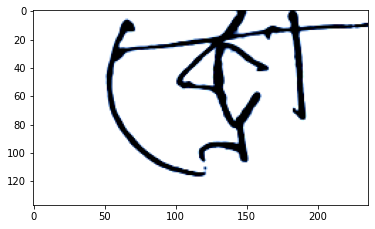

In [ ]:
idx = 0
img = dataset[idx]['image']
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2 ,0)))
print(dataset[idx]['grapheme_root'])

In [46]:
dataset_test = BengaliDatasetLoader_Test(img_height=137, img_width=236, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [43]:
len(dataset_test)

12

In [48]:
dataset_test[0]

{'image': tensor([[[2.1119, 2.2147, 2.2147,  ..., 2.1975, 2.1975, 2.1975],
          [2.1290, 2.1975, 2.1975,  ..., 2.1975, 2.1462, 2.1804],
          [2.0948, 2.1804, 2.1804,  ..., 2.1975, 2.1975, 2.2147],
          ...,
          [2.1975, 2.2147, 2.1975,  ..., 2.1804, 2.1804, 2.1804],
          [2.1975, 2.2147, 2.2147,  ..., 2.1804, 2.2147, 2.2147],
          [2.1633, 2.1804, 2.1975,  ..., 2.2147, 2.1975, 2.1633]],
 
         [[2.2885, 2.3936, 2.3936,  ..., 2.3761, 2.3761, 2.3761],
          [2.3060, 2.3761, 2.3761,  ..., 2.3761, 2.3235, 2.3585],
          [2.2710, 2.3585, 2.3585,  ..., 2.3761, 2.3761, 2.3936],
          ...,
          [2.3761, 2.3936, 2.3761,  ..., 2.3585, 2.3585, 2.3585],
          [2.3761, 2.3936, 2.3936,  ..., 2.3585, 2.3936, 2.3936],
          [2.3410, 2.3585, 2.3761,  ..., 2.3936, 2.3761, 2.3410]],
 
         [[2.5006, 2.6051, 2.6051,  ..., 2.5877, 2.5877, 2.5877],
          [2.5180, 2.5877, 2.5877,  ..., 2.5877, 2.5354, 2.5703],
          [2.4831, 2.5703, 2.57

## Model
---

In [21]:

class ResNet34(nn.Module):
  def __init__(self, pretrained):
    super(ResNet34, self).__init__()
    if pretrained:
      self.model = pretrainedmodels.__dict__['resnet34'](pretrained = 'imagenet')
    else:
      self.model = pretrainedmodels.__dict__['resnet34'](pretrained = None)
    self.l0 = nn.Linear(512, 168)
    self.l1 = nn.Linear(512, 11)
    self.l2 = nn.Linear(512, 7)
  
  def forward(self, x):
    bs,_,_,_ = x.shape
    x = self.model.features(x)
    x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
    l0 = self.l0(x)
    l1 = self.l1(x)
    l2 = self.l2(x)
    return l0, l1, l2

## Loss Function
---
> I'm using **Cross Entropy Loss**

In [22]:
def loss_fn(outputs, targets):
  o1, o2, o3 = outputs
  t1, t2, t3 = targets
  l1 = nn.CrossEntropyLoss()(o1, t1)
  l2 = nn.CrossEntropyLoss()(o2, t2)
  l3 = nn.CrossEntropyLoss()(o3, t3)
  return (l1 + l2 + l3)/ 3

## Training Functions
---

In [23]:
def train_helper(model, dataset, dataloader, optimizer):
  model.to(device)
  model.train()
  for bi, d in tqdm_notebook(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
    grapheme_root = d['grapheme_root']
    vowel_diacritic = d['vowel_diacritic']
    consonant_diacritic = d['consonant_diacritic']
    image = d['image']
    
    image = image.to(device, dtype=torch.float)
    grapheme_root = grapheme_root.to(device, dtype=torch.long)
    vowel_diacritic = vowel_diacritic.to(device, dtype=torch.long)
    consonant_diacritic = consonant_diacritic.to(device, dtype=torch.long)

    optimizer.zero_grad()

    outputs = model(image)
    targets = (grapheme_root, vowel_diacritic, consonant_diacritic)

    loss = loss_fn(outputs, targets)
    
    loss.backward()
    optimizer.step()

In [24]:
def train_fn(model, device, img_height, img_width, epochs, batch_size_train, batch_size_val, mean, std, training_folds, validation_folds):
  model.to(device)
  training_dataset = BengaliDatasetLoader(folds=training_folds, 
                                          img_height=img_height, 
                                          img_width=img_width, 
                                          mean=mean, 
                                          std=std)
  train_loader = torch.utils.data.DataLoader(dataset=training_dataset, 
                                             batch_size=batch_size_train, 
                                             shuffle=True,
                                             num_workers=4)
  
  validation_dataset = BengaliDatasetLoader(folds=validation_folds, 
                                          img_height=img_height, 
                                          img_width=img_width, 
                                          mean=mean, 
                                          std=std)
  validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                             batch_size=batch_size_val, 
                                             shuffle=False,
                                             num_workers=4)
  
  optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optim, mode='min', patience=5, factor=.3)

  for epoch in range(epochs):
    clear_output(wait=True)
    print(f'Epoch:{epoch+1}/{epochs}')
    print('Training...')
    train_helper(model, training_dataset, train_loader, optim)
    print('Validating...')
    val_score = eval_helper(model, validation_dataset, validation_loader)
    scheduler.step(val_score)
    if(epoch % 10 == 0):
      torch.save(model.state_dict(), f'/content/drive/My Drive/Bengali_ai_outputs/ResNet34_fold{validation_folds[0]}_epoch{epoch}.bin')
  torch.save(model.state_dict(), f'/content/drive/My Drive/Bengali_ai_outputs/ResNet34_fold{validation_folds[0]}.bin')
  return model

## Evaluation function
---

In [25]:
def eval_helper(model, dataset, dataloader):
  model.to(device)
  model.eval()

  final_loss = 0
  counter = 0

  for bi, d in tqdm_notebook(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
    
    counter += 1
    
    grapheme_root = d['grapheme_root']
    vowel_diacritic = d['vowel_diacritic']
    consonant_diacritic = d['consonant_diacritic']
    image = d['image']
    
    image = image.to(device, dtype=torch.float)
    grapheme_root = grapheme_root.to(device, dtype=torch.long)
    vowel_diacritic = vowel_diacritic.to(device, dtype=torch.long)
    consonant_diacritic = consonant_diacritic.to(device, dtype=torch.long)

    outputs = model(image)
    targets = (grapheme_root, vowel_diacritic, consonant_diacritic)

    loss = loss_fn(outputs, targets)
    final_loss += loss.item()
  return final_loss / counter

## Training Configuration
---

In [26]:

device ='cuda'
model = ResNet34(True)
Training_Folds_CSV = '/content/training_set/train_folds.csv'

Img_Height = 137 #Given constant values for the images
Img_Width = 236

Epochs = 50
BatchSize_Train = 256
BatchSize_Test = 256

Mean = (0.485, 0.456, 0.406)    #Standard Values for the ResNet model
Std = (0.229, 0.224, 0.225)


Training_Folds = (0, 1, 2, 4)
Validation_Folds = (3,)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


## Training
---

In [41]:
model = train_fn(model, device, Img_Height, Img_Width, Epochs, BatchSize_Train, BatchSize_Test, Mean, Std, Training_Folds, Validation_Folds)

Epoch:39/50
Training...


Buffered data was truncated after reaching the output size limit.

## Predictions on Test Data
---

In [35]:
model.load_state_dict(torch.load('/content/drive/My Drive/Bengali_ai_outputs/ResNet34_fold3.bin'))

<All keys matched successfully>

In [53]:
model.to(device)
model.eval()
test_dataset = BengaliDatasetLoader_Test( img_height=Img_Height, 
                                          img_width=Img_Width, 
                                          mean=Mean, 
                                          std=Std)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=BatchSize_Test, 
                                            shuffle=False,
                                            num_workers=4)

for d in tqdm_notebook(test_loader, total=len(test_loader)):
  image = d['image']
  img_id = d['image_id']
  image = image.to(device, dtype=torch.float)

  g, v, c =model(image)

  g = np.argmax(g.cpu().detach().numpy(), axis=1)
  v = np.argmax(v.cpu().detach().numpy(), axis=1)
  c = np.argmax(c.cpu().detach().numpy(), axis=1)
  preds = [(id,[g[i], v[i], c[i]]) for i, id in enumerate(img_id)]

In [54]:
preds

[('Test_0', [3, 0, 0]),
 ('Test_1', [93, 2, 0]),
 ('Test_2', [19, 0, 0]),
 ('Test_3', [115, 0, 0]),
 ('Test_4', [55, 4, 0]),
 ('Test_5', [115, 2, 0]),
 ('Test_6', [147, 9, 5]),
 ('Test_7', [137, 7, 0]),
 ('Test_8', [119, 9, 0]),
 ('Test_9', [133, 10, 0]),
 ('Test_10', [148, 1, 4]),
 ('Test_11', [21, 2, 0])]

**Note** : I have done training andinference with just one fold due to the time and resource constraints